In [1]:
# saerch for decorator 3:41 

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
# %matplotlib inline?

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [67]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27x10

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) 
#* 0.2 ??-- from the paper to get unit norm
# kimming inint
# batch normalization
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

# # BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
print(f"shape of C {C.shape}\nshape of W1 {W1.shape}, b1 {b1.shape}, W2 {W2.shape},B2 {b2.shape}")

parameters = [C, W1, W2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

shape of C torch.Size([27, 10])
shape of W1 torch.Size([30, 200]), b1 torch.Size([200]), W2 torch.Size([200, 27]),B2 torch.Size([27])
12097


tensor(-0.0061) tensor(1.0045)
tensor(-0.0031) tensor(1.0292)


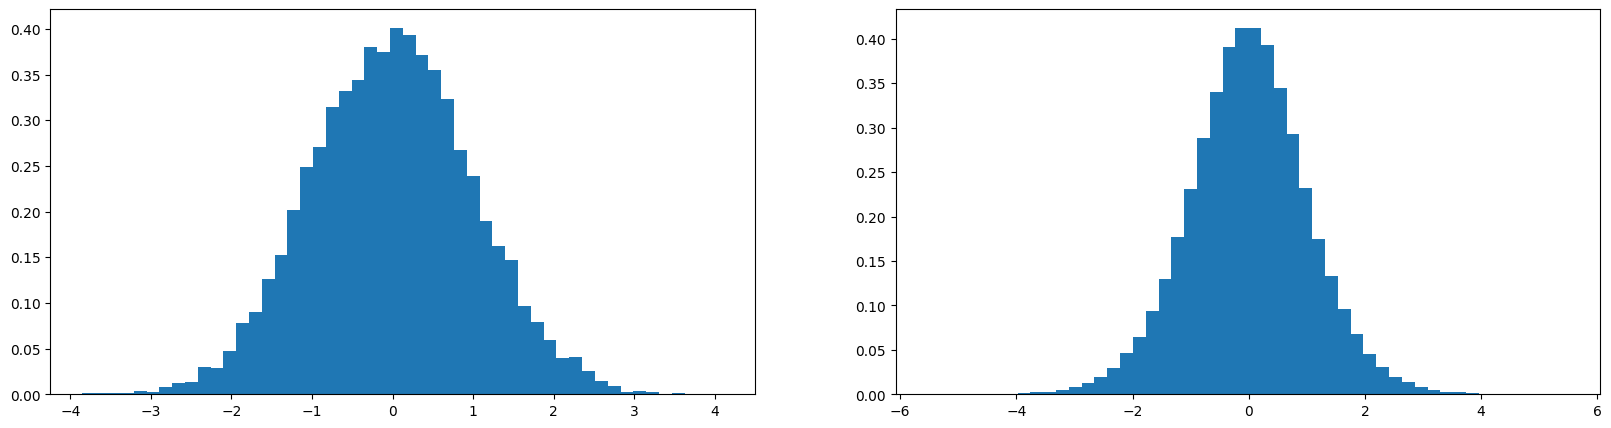

In [68]:
x=torch.randn(1000,10)
W=torch.randn(10,200) / 10**0.5  # number of dim of col of x ka square root--> fan in
y=x@W
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);

In [69]:
# print(n_embd ,block_size)
"""
tricks in 4th video(till 1st hour)
1. last layer uniform init(reason: no reason to believe one output over the other at initialization)
2. Kaiming init (reason: vanishing gradient; if the input to tanh has large variance, a lot of neurons 
    will not learn in the backprop, thus we need to initialize W such that its output (i.e. input of tanh) 
    becomes standard normal before feeding it to tanh; )-> could become difficult to configure if the network becomes large. 
    Use batch norm instead
3. batch norm:- instead of configuring W to make its output std. normal, we directly do std normalization on the output of W 
    before feeding it to tanh
    (IMP: vanishing gradient in its worst form can turn a neuron into a dead neuron, in that case that neuron will forever
    cease to learn over the whole training)
4. We want to hpreact roughly gausian coz if they are too small, tanh wont have effect, if too large- may saturate the sell 
"""

'\ntricks in 4th video(till 1st hour)\n1. last layer uniform init(reason: no reason to believe one output over the other at initialization)\n2. Kaiming init (reason: vanishing gradient; if the input to tanh has large variance, a lot of neurons \n    will not learn in the backprop, thus we need to initialize W such that its output (i.e. input of tanh) \n    becomes standard normal before feeding it to tanh; )-> could become difficult to configure if the network becomes large. \n    Use batch norm instead\n3. batch norm:- instead of configuring W to make its output std. normal, we directly do std normalization on the output of W \n    before feeding it to tanh\n    (IMP: vanishing gradient in its worst form can turn a neuron into a dead neuron, in that case that neuron will forever\n    cease to learn over the whole training)\n4. We want to hpreact roughly gausian coz if they are too small, tanh wont have effect, if too large- may saturate the sell \n'

In [70]:
hpreact.mean(0,keepdim=True).shape
hpreact.std(0,keepdim=True).shape


torch.Size([1, 200])

In [71]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # does that 3*10 things by itself if we put -1
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # batch norm steps
  bnmeani=hpreact.mean(0,keepdim=True)
  bnstdi=hpreact.std(0,keepdim=True)
  hpreact=bngain*(hpreact- bnmeani)/bnstdi +bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # --------------------------------------------------------


  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3147


In [72]:
# plt.plot(lossi)

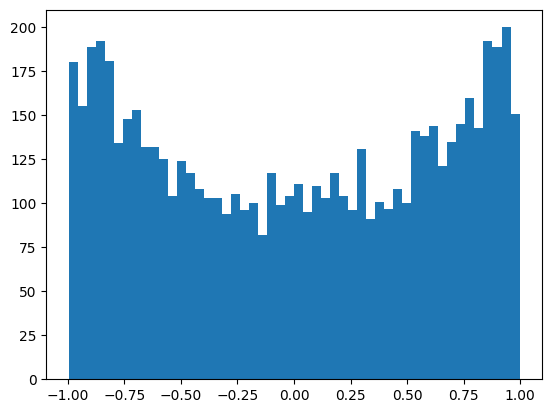

In [73]:
plt.hist(h.view(-1).tolist(),50);

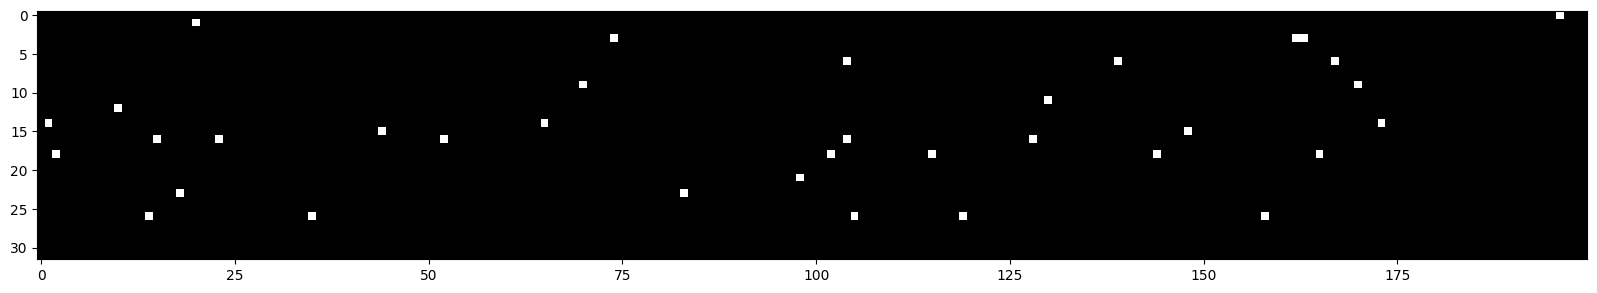

In [74]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray', interpolation='nearest')

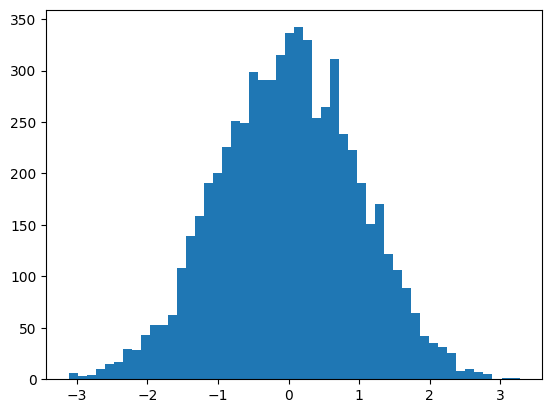

In [75]:
plt.hist(hpreact.view(-1).tolist(),50);

In [76]:
@torch.no_grad() # this decorator disables gradient tracking
# i will not call backprop on the below code
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact=embcat@W1+b1
 # batch norm steps
  mean=hpreact.mean(0,keepdim=True)
  std=hpreact.std(0,keepdim=True)
  hpreact=bngain*(hpreact- mean)/std +bnbias



#   hpreact = embcat @ W1 # + b1
#   #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
#   hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.268287420272827
val 3.267737627029419


In [77]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [78]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.2688050270080566
val 3.268404722213745


In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net=b1
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1,-1)@W1+b1) #emb.view(emb.shape[0], -1) # concatenate the vectors
      logits = h@W2+b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
nah.
yam.
remmani.
jerneg.
adeer.
meliah.
miloen.
eden.
esmanar.
kayzion.
kamin.
shubergshiriel.
kenie.
jenelle.
pachiu.
zen.
dariyah.


In [ ]:
# loss log

# original
train=2.12
val=2.16

# fix softmax confidentely wrong
train = 2.07
val = 2.13


# fix tanh layer to saturate at init
train = 2.03
val = 2.10


In [6]:
# # MLP revisited
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C  = torch.randn((vocab_size, n_embd),            generator=g) # 27x10
# print(f"shape of C {C.shape}")
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2 ??
# #b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# b2 = torch.randn(vocab_size,                      generator=g) * 0

# # BatchNorm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, W2, b2, bngain, bnbias]
# print(sum(p.nelement() for p in parameters)) # number of parameters in total
# for p in parameters:
#   p.requires_grad = True
# 12097

12097


12097

In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


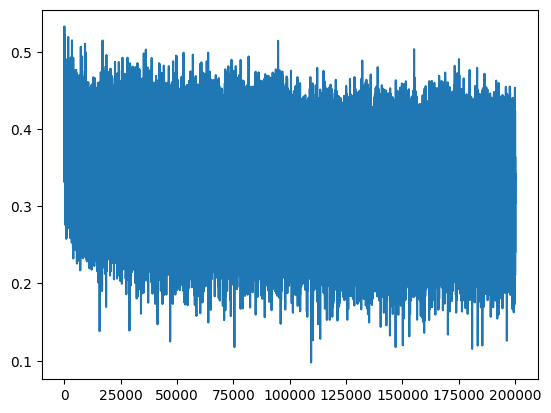

In [8]:
plt.plot(lossi)

In [ ]:
-torch.tensor(1/27.0).log() # why do we expect this loss??

In [14]:
# 4 -diemnsional example of the issue
logits= torch.tensor([0.0,0.0,0.0,0.0])
print(logits.shape)
probs=torch.softmax(logits,dim=0)

loss=-probs[2].log() # label is 2 so second logits
probs,loss

torch.Size([4])


(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')